In [1]:
%cd '/home/threadripper/PycharmProjects/coh_analysis'

/home/threadripper/PycharmProjects/coh_analysis


In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

from services.coherence_service import CoherenceService

In [3]:
mpl.rcParams['figure.dpi'] = 200
sns.set_style("whitegrid")
alpha=0.9

In [4]:
def smooth(scalars: list[float], weight: float) -> list[float]:
    """
    EMA implementation according to
    https://github.com/tensorflow/tensorboard/blob/34877f15153e1a2087316b9952c931807a122aa7/tensorboard/components/vz_line_chart2/line-chart.ts#L699
    """
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in scalars:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return smoothed

In [5]:
def plot(coherences, ax=None, upper_data=1000):
    colors = list(plt.cm.tab10(np.arange(10))) + ["indigo"]
    if ax is None:
        ax = plt.gca()
    for i, (label, pair_list) in enumerate(coherences.items()):
        mean, mx = [], []
        for x, ys in pair_list:
            if x > upper_data:
                continue
            if len(ys) <= 0:
                continue
            np_array = np.array(ys)
            mx.append(x)
            mean.append(np.mean(np_array))
        
        ax.plot(mx, mean , label=label, color=colors[i])
    
    ax.grid('both')
    ax.set_xlabel('Length')
    ax.set_ylabel('coherences')
    return ax

In [6]:
coherence_service = CoherenceService()
coherence_service.load_from_cache()

In [7]:
def to_coherence(coherence_service, attribute='length', label='danceability', f=None, begin=None):
    mapping = {}
    for key, coherence in coherence_service.data[[attribute, label]].dropna().values:
        if f is not None:
            key = f(key)
        mapping.setdefault(key, []).append(coherence)
    coherences = list(mapping.items())
    coherences.sort()
    if begin is not None:
        coherences[0] = (begin, coherences[0][1])
    return coherences

In [8]:
coherence_length = {}
for label in coherence_service.dependent_variables:
    coherence = to_coherence(coherence_service, attribute='length', label=label, f=lambda x: int(x / 10)*10, begin=11)
    coherence_length[label] = coherence

In [9]:
coherence_edits = {}
for label in coherence_service.dependent_variables:
    coherence = to_coherence(coherence_service, attribute='num_edits', label=label, f=lambda x: int(x / 10)*10, begin=2)
    coherence_edits[label] = coherence

In [10]:
coherence_popularity = {}
for label in coherence_service.dependent_variables:
    coherence = to_coherence(coherence_service, attribute='popularity', label=label,
                             f=lambda x: int(2*x)/2)
    coherence_popularity[label] = coherence

<Axes: xlabel='Length', ylabel='coherences'>

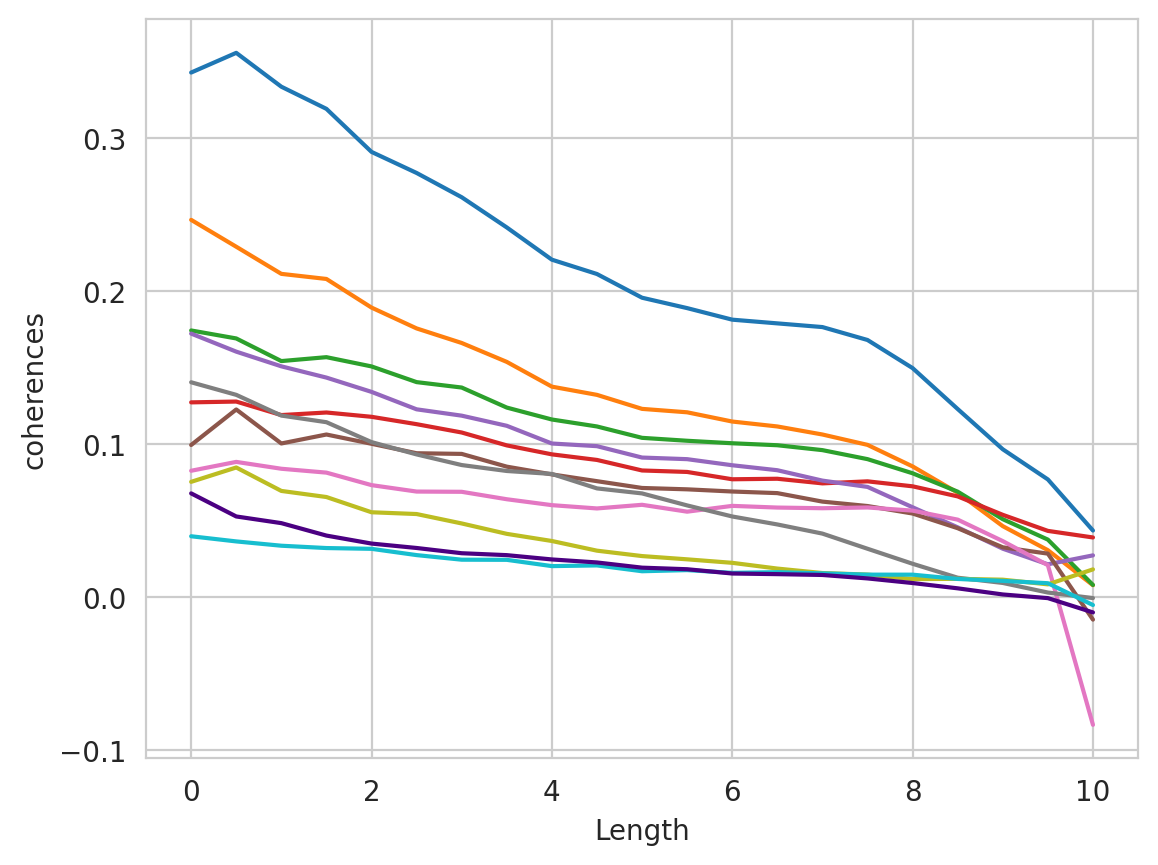

In [11]:
plot(coherence_popularity)

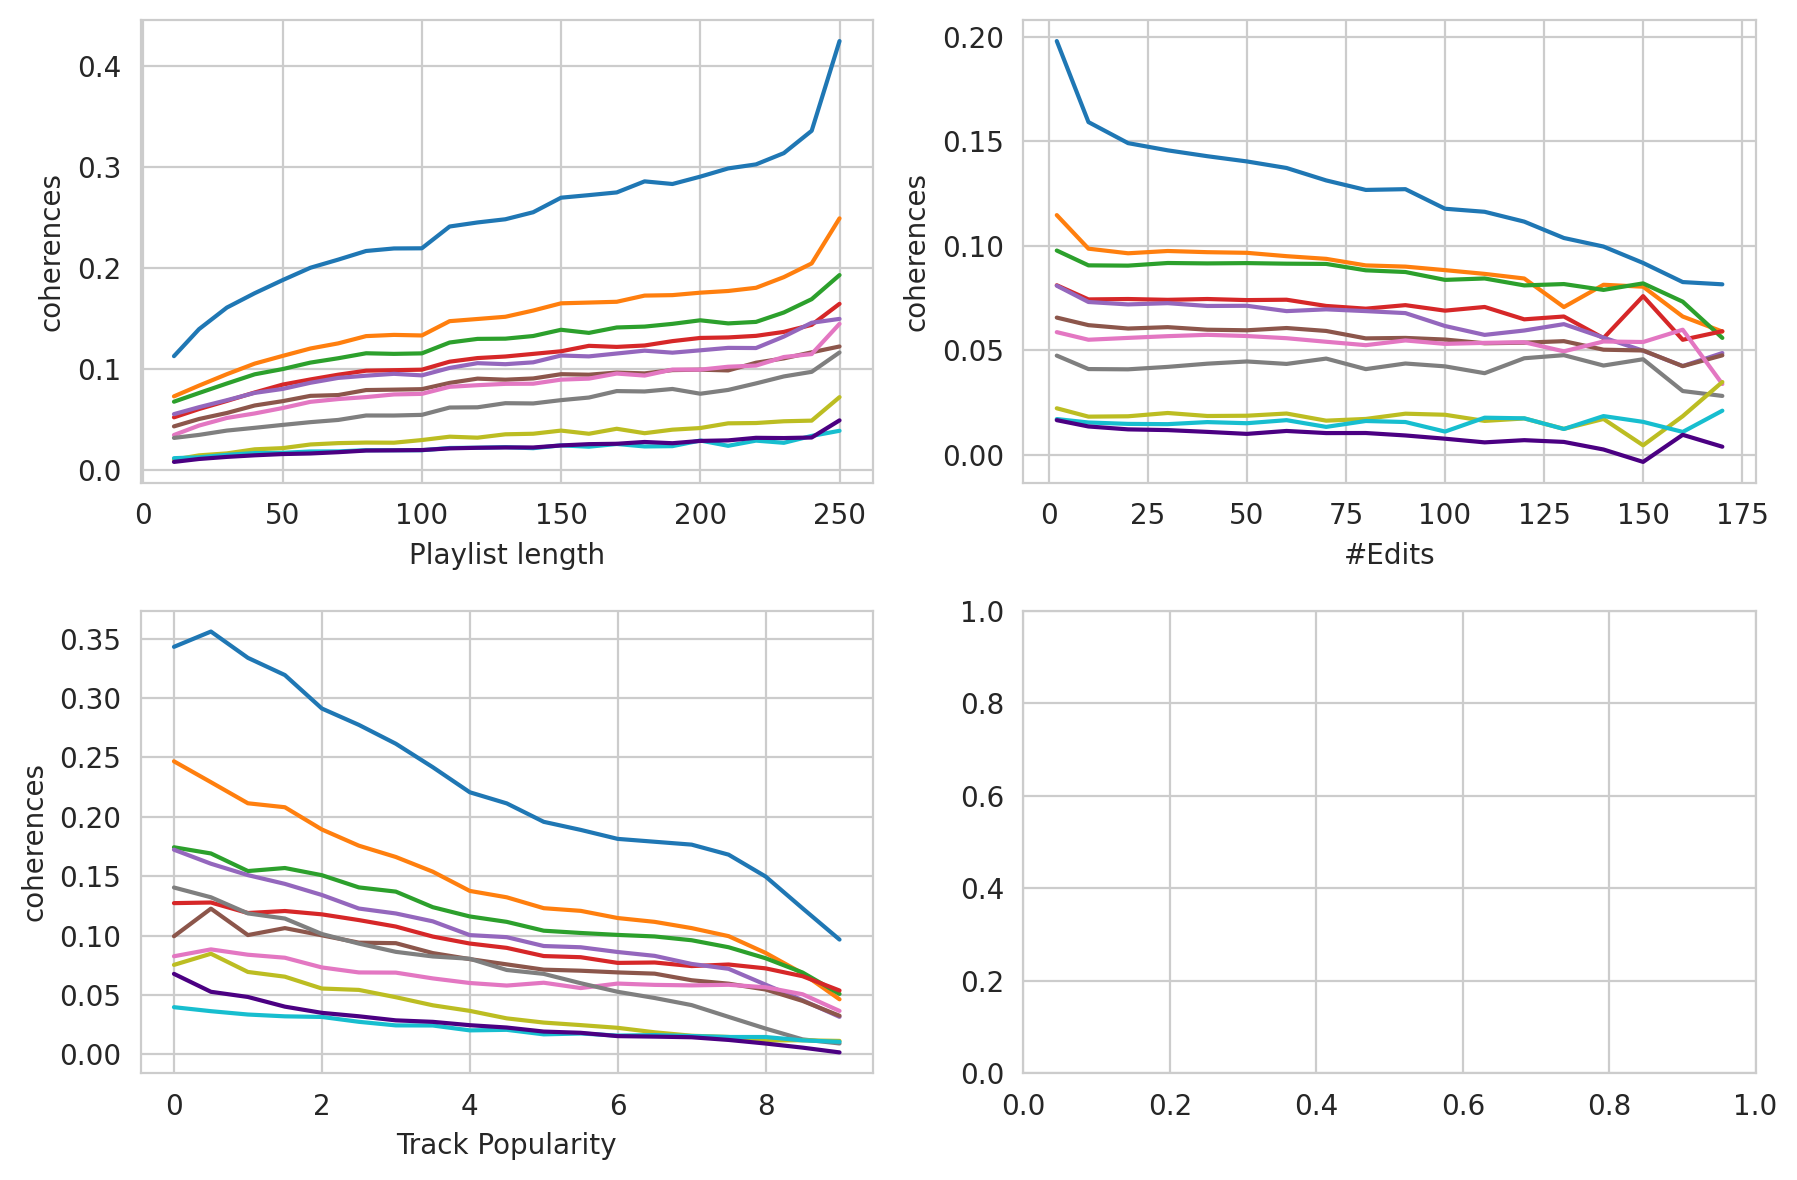

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 6))
plot(coherence_length, ax=ax[0, 0])
ax[0, 0].set_xlabel('Playlist length')
plot(coherence_edits, ax=ax[0, 1], upper_data=175)
ax[0, 1].set_xlabel('#Edits')
plot(coherence_popularity, ax=ax[1, 0], upper_data=9)
ax[1, 0].set_xlabel('Track Popularity')
#ax[1, 0].legend(loc=(1.04, 0))
plt.tight_layout()
plt.savefig('plots/fig_results_without_legend.png')
plt.show()

In [13]:
rows = []
sums = [[[0, 0], [0, 0]] for _ in range(11)]
for index, row in coherence_service.data.iterrows():
    for i, label in enumerate(coherence_service.dependent_variables):
        value = row[label]
        collaborative = row['c_collaborative']
        if not np.isnan(value):
            rows.append([label, value, collaborative])
            if collaborative:
                sums[i][1][0] += value
                sums[i][1][1] += 1
            else:
                sums[i][0][0] += value
                sums[i][0][1] += 1
df = pd.DataFrame(rows, columns=['feature', 'coherence', 'collaborative'])
means = [(s[0][0] / s[0][1], s[1][0] / s[1][1]) for s in sums]
means

[(np.float64(0.17541569463504836), np.float64(0.16080019561826825)),
 (np.float64(0.10605800111694359), np.float64(0.11183926704450445)),
 (np.float64(0.09423787380763604), np.float64(0.09763616073464677)),
 (np.float64(0.07760804291822682), np.float64(0.08262434480941797)),
 (np.float64(0.07646837440921599), np.float64(0.08384023145189726)),
 (np.float64(0.06318379837682328), np.float64(0.07305993574194176)),
 (np.float64(0.05710618865822106), np.float64(0.061135492988689394)),
 (np.float64(0.04419061271608262), np.float64(0.05904390507160891)),
 (np.float64(0.020446283220741414), np.float64(0.01980541901149133)),
 (np.float64(0.01616706433241506), np.float64(0.016899689650428942)),
 (np.float64(0.014512789028519914), np.float64(0.017056239271969018))]

/tmp/ipykernel_31017/196731972.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


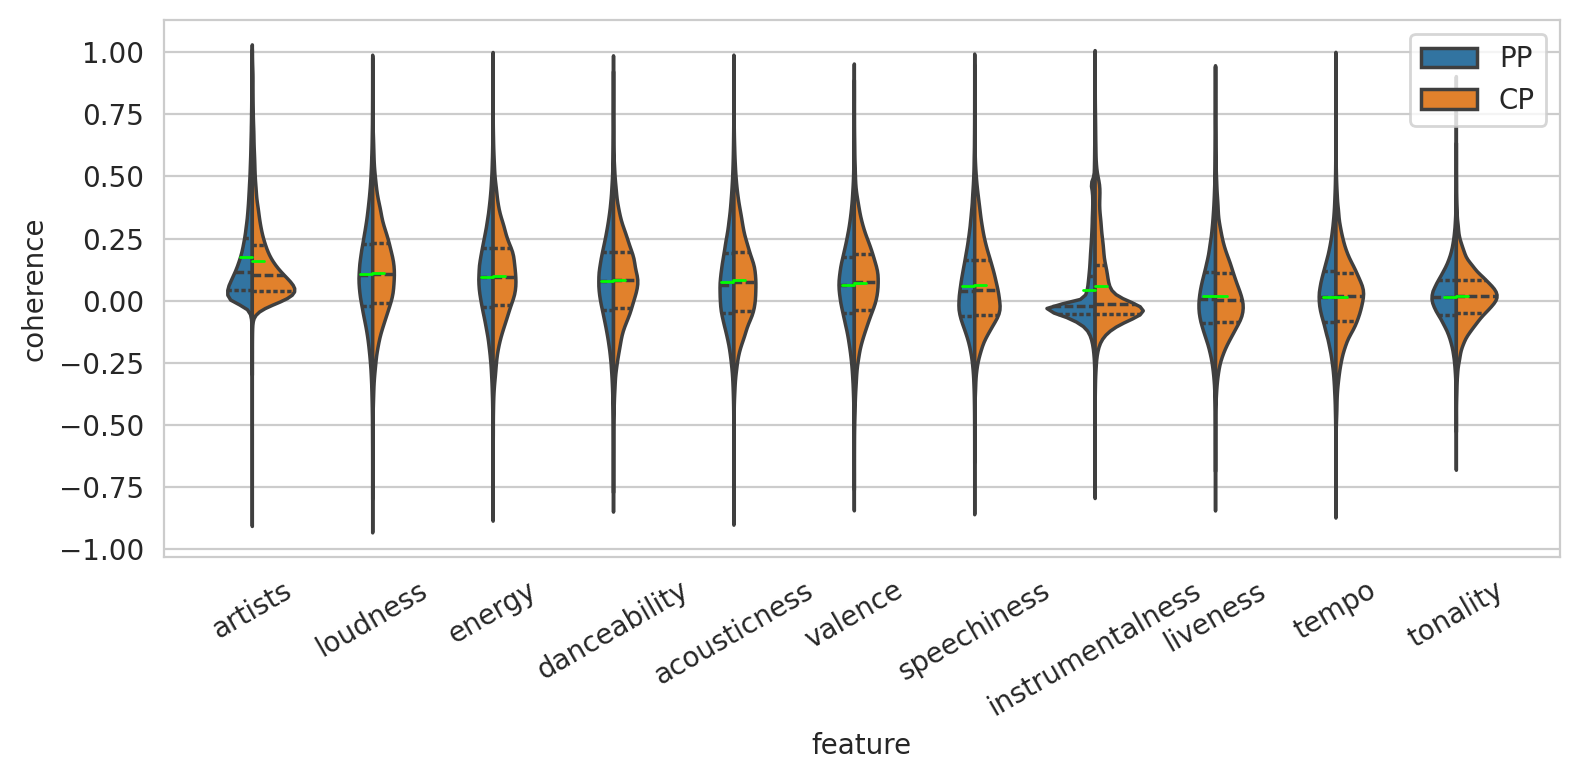

In [14]:
plt.figure(figsize=(8, 4))
ax = sns.violinplot(df, hue='collaborative', x='feature', y='coherence', split=True, inner='quart')
for i, mean in enumerate(means):
    plt.plot([i-0.1, i], [mean[0], mean[0]], linewidth=1, color='lime')
    plt.plot([i, i+0.1], [mean[1], mean[1]], linewidth=1, color='lime')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=['PP', 'CP'], loc='upper right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.tight_layout()
plt.savefig('plots/fig_collaborative_results.png')
plt.show()